## Paweł Biel
## Bartłomiej Kmiecik

#### Zastosowania Machine Learning / Big Data
#### Grupa I - Informatyka w Biznesie - studia niestacjonarne
#### Rok akademicki: 2020/2021

## Import bibliotek

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras.layers import Dense # głęboko połączona warstwa przekazująca neurony dalej (batch, size)
from tensorflow.keras.layers import Flatten # "spłaszcza" dane wejściowe, przekształca w 1wymiarową tablicę; nie wpływa na wielkość partii
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization #warstwa normalizująca dane wejściowe
from tensorflow.keras.layers import Dropout # odrzuca część losową informacji, gdy sieć wyciąga za dużo informacji
from tensorflow.keras.layers import LSTM # warstwa pamięci długookresowej (sztuczna rekurencyjna architektura sieci neuronowej RNN)
from tensorflow.keras.models import Model # grupuje warstwy w obiekt z funkacjami uczenia i wnioskowania
from tensorflow.keras.models import Sequential, load_model # do zaczytywania i wczytywania modelu
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display # tworzymy obiekt audio 
import ipywidgets as widgets
from ipywidgets import interact, interact_manual # automatyczne tworzenie kontrolek interfejsu użytkownika  (user interface UI)
from ipywidgets import interactive

from sklearn.model_selection import train_test_split # dzielenie tablic lub macierzy na losowe podzbioru trenowania i testowania. 
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from sklearn.metrics import r2_score # R2- współczynnik determinacji; funkcja oceny regresji 
from sklearn.metrics import mean_absolute_error #MAE oraz MSE (błędy)
from sklearn.metrics import mean_squared_error

import math
import keras
from keras.models import Sequential
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler # przekształcanie cech skalując każdą z cech do określonego zakresu
from keras.callbacks import EarlyStopping

# Funkcje pomocnicze

### Podział zbioru danych na treningowy i testowy

In [2]:
def prepare_dataset_to_lstm(predicted_variable_name, train_df, ratio):
  dataset = train_df[predicted_variable_name].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamiana typu na float
  dataset = np.reshape(dataset, (-1, 1)) #przekształcamy tablicę; wynikowa tablica ma tylko 1 kolumnę
  scaler = MinMaxScaler(feature_range=(0, 1)) #skalowanie zmiennych do postaci (0,1)
  dataset = scaler.fit_transform(dataset) # wszystkie inne wartości są liniowo skalowane między tymi wartościami

#podział uporządkowanego zestawu danych do trenowania i testowania.
  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler

### Tworzenie zbioru danych LSTM

In [3]:
# look_back- liczba poprzednich kroków czasowych, które mają być użyte jako zmienne wejściowe do przewidywania następnego okresu czasu, w tym przypadku domyślnie 1.
# scaler- normalizuje dane do zakresu (0,1)
# tworzenie back(ów); konwersja tablicy wartości na macierz zestawu danych
def create_dataset_lstm(dataset, look_back=1):   #look_back - wielkość kroku z którą testujemy dataset
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

### Utworzenie modelu

In [4]:
#Tworzymy i dopasowujemy model LSTM (zmiana batch_size). W poniższym modelu jest jedno wejście w warstwie wejściowej
# i 10 neuronów w warstwie ukrytej. Warstwa wyjściowa przewiduje wartości
def lstm_model(X_train, Y_train, X_test, Y_test, batch_size=20):
  model = Sequential()  #liniowy stos warstw
  model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2)) 
  model.add(Dense(5))
# definiujemy w czym będziemy wyrażać naszą jakość uczenia
  model.compile(loss='mean_squared_error', optimizer='adam') #definiujemy w czym będziemy wyrażać naszą jakośc uczenia

# epochs - Funkcja aktywacji powtarzana jest 5 razy
  history = model.fit(X_train, Y_train, epochs=5, batch_size=10, validation_data=(X_test, Y_test), 
                      # przerwij trenowanie, gdy monitorowana metryka przestanie się poprawiać
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
  return model

### Ewaluacja modelu 

In [5]:
def evaluation_model(model,X_train, X_test, Y_train, predicted_variable_name, testing=False):
  dataset = train_df[predicted_variable_name].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))  # zmienia shape na odwrotny (odwrócenie macierzy) nie w sposób ciągły (1 pod 2)
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  
#wykonaj prognozy
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

#odwróć prognozy, przy obliczaniu błędu przekonwertujemy dane na tą samą jednostkę.  
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])

#oblicz średni kwadrat błędu
  _mean_absolute_error = mean_absolute_error(Y_train[0], train_predict[:,0])   #jak mamy listę 13 elementów, to wstawiając [3,:] pobierze od 3 do 13 elementu
  _mean_squared_error = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
  print('Train Mean Absolute Error:', _mean_absolute_error)
  print('Train Root Mean Squared Error:',_mean_squared_error)
  if testing:
    return Y_train, train_predict, _mean_absolute_error, _mean_squared_error
  return Y_train, train_predict

### Funkcja do wizualizacji

In [6]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0]) 
  aa=[x for x in range(N)]  # N oznacza liczbę cech w punkcie danych
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual") # gdy . zmienimy na * to będziemy mieli zamiast . -> *
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()  # dostosuj dopełnienie między polamy pomocniczymi i wokół nich
  sns.despine(top=True) # usuwamy grzbiet
  plt.subplots_adjust(left=0.07)  # położenie lewej krawędzi wykresu
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)  # rozmiar czcionki dla time step 15
  plt.legend(fontsize=15)  # rozmiar czcionki elementów legendy
  plt.show();  # uruchamiamy pętle zdarzeń, wyszukujemy wszystkie aktywne obiekty figur i otwieramy jedno lub więcej inteaktywnych okien.



# Import i scalenie danych 

In [7]:
import os
import pandas as pd

data = pd.read_csv('data//eth_v_d.csv', index_col='Data')

files=os.listdir('data/')
files.remove('eth_v_d.csv')

for file in files:
  print(file+'\n');
  right = pd.read_csv('data/'+file, index_col='Data', engine='python')
  main_table = data.merge(right=right, 
                                how = 'inner', 
                                left_index=True, 
                                right_index=True, 
                                copy=False, 
                                suffixes=('','_'+file[:-4]))

data.head()

bch_v_d.csv

bnb_v_d.csv

btc_v_d (1).csv

comp_v_d.csv

eurchf_d.csv

eurpln_d.csv

eurusd_d.csv

fw20_d.csv

mkr_v_d.csv

usdchf_d.csv

usdeur_d.csv

usdpln_d.csv

wig20_d.csv

wig_d.csv



,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie
Data,,,,
2015-08-07,3.0,3.0,3.0000,3.00
2015-08-08,3.0,3.0,1.2000,1.20
2015-08-09,1.2,1.2,1.2000,1.20
2015-08-10,1.2,1.2,1.2000,1.20
2015-08-11,1.2,1.2,0.6504,0.99


# Czyszczenie danych z pustych rekordów

In [8]:
print("Dane przed usunięciem NaN:", len(data), "liczba kolumn: ", len(data.columns))
data = data.dropna()
print("Dane po usunięciu NaN:", len(data), "liczba kolumn: ", len(data.columns))

Dane przed usunięciem NaN: 2072 liczba kolumn:  4
Dane po usunięciu NaN: 2072 liczba kolumn:  4


In [9]:
# pierwsza liczba oznacza ilość wierszy, natomiast druga ilość kolumn w zbiorze danych
print(data.shape)

(2072, 4)


In [10]:
# zbiór treningowy
ratio = 0.6  # współczynnik proporcji wymiarów (0.6 w stosunku do całego zbioru danych)
N = int(len(data)*ratio)   # liczba próbek na klasę
train_df, test_df = data[:N], data[N:]   # przypisanie próbek do zmiennych
print(train_df.shape)

(1243, 4)


In [11]:
# zbiór testowy
ratio = 0.5
N = int(len(data)*ratio)
test_df, val_df = test_df[:N], test_df[N:]
print(test_df.shape)

(829, 4)


In [12]:
# podsumowanie statystyk odnoszących się do kolumny DataFrame 
# ta funkcja podaje wartości średnie, standardowe i odstęp międzykwartylowy
train_df.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie
count,1243.000000,1243.000000,1243.000000,1243.000000
mean,209.190909,218.160156,198.442360,209.302651
std,272.820407,285.257570,257.265208,272.770696
min,0.420000,0.471900,0.411000,0.420000
25%,10.075000,10.565000,9.655000,10.090000
50%,50.090000,52.220000,48.450000,50.250000
75%,313.885000,324.735000,300.190000,313.885000
max,1385.020000,1422.860000,1271.070000,1385.020000


In [13]:
# zapewnia obliczania w oknie kroczącym
# windows = rozmiar ruchomego okna, jest to liczba obserwacji użytych do obliczenia statystyki 
# każde okno będzie miało stały rozmiar
rolling = data.rolling(window=7)

In [14]:
# wskazanie zmiennej do predycji
data_roll = pd.DataFrame()
data_roll['Zamkniecie']=train_df['Zamkniecie']

In [15]:
@widgets.interact_manual(lw=(1, 100))
def plot(lw):
  rolling = data.rolling(window=lw, center=True)
  data_roll = pd.DataFrame()
 
  data_roll['Zamkniecie']=data['Zamkniecie']
  data_roll['7 days rolling_mean(srednia kroczaca)']=data_roll['Zamkniecie'].rolling(lw, min_periods=1).mean()
  ax = data_roll.plot(style=['-', '--'], rot=90, figsize=(20, 10)) 
  ax.lines[0].set_alpha(0.3)

interactive(children=(IntSlider(value=50, description='lw', min=1), Button(description='Run Interact', style=B…

In [16]:
# wywołanie metody przygotowującej model pod LSTM
predicted_variable_name = "Zamkniecie"
train, test, scaler = prepare_dataset_to_lstm(predicted_variable_name, train_df, ratio=0.8) #scaler - normalizuje dane do zakresu (0,1)

In [17]:
#przygotowanie zestawów uczących i testowych do modelowania
look_back = 20
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

#Przeszktałcenie DataFrame-u do modelu
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [18]:
#Uczenie modelu
history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10)

# loss - funkcja straty na zbiorze treningowym
# val_loss - funkcja straty na zbiorze walidacyjnym (im mniejsza tym lepiej)

Epoch 1/5
98/98 [==============================] - 3s 13ms/step - loss: 0.0020 - val_loss: 0.0076
Epoch 2/5
98/98 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0013
Epoch 3/5
98/98 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 4/5
98/98 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 5/5
98/98 [==============================] - 0s 2ms/step - loss: 8.2566e-04 - val_loss: 0.0018


In [19]:
# zapis modelu sieci neuronowej w formacie JSON
model_json = history.to_json()  #zapisanie modelu history do JSON
with open("model.json", "w") as json_file:  #utworzenie pliku model.json w trybie edycji i zatrzymanie w zmiennej json_file
    json_file.write(model_json)
# zapisanie wagi z modelu za pomocą funkcji save.weights. 
history.save_weights("model.h5")  #wagi są zapisywane w pliku model.h5 w katalogu lokalnym.
print("Saved model to disk")  #komentarz udanej operacji

Saved model to disk


### Ewaluacja modelu

In [20]:
Y_train, train_predict = evaluation_model(history,X_train, X_test, Y_train, predicted_variable_name)

Train Mean Absolute Error: 38.96091879080384
Train Root Mean Squared Error: 60.34157082919831


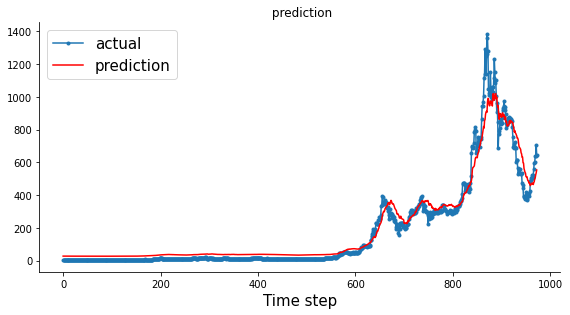

In [21]:
# Na wykresie dane nie są znormalizowane
visualization(Y_train, train_predict) # niebieska- z csv wiersze i do nich wartości z pliku excel; czerwone- dla poszczegolnych wierszy błędy;

In [22]:
# Ponowny podział na zbiory treningowy i walidacyjny
train, test, scaler = prepare_dataset_to_lstm(predicted_variable_name, train_df, ratio=0.8)

look_back = 3 
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# wielkość próbki
batch_start, batch_end = 20, 30
look_backs = [3,10,30]


error_look_back = {}
for look_back in look_backs:
  MAEs = []
  MSEs = []
  Y_trains = []
  train_predicts = []

  X_train, Y_train = create_dataset_lstm(train, look_back)
  X_test, Y_test = create_dataset_lstm(test, look_back)
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  for batch in range(batch_start, batch_end):
    print(f'-------------------------------{batch}--------------------------')
    history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=batch)
    tmp_Y_train, tmp_train_predict, MAE, MSE  = evaluation_model(history,X_train, X_test, Y_train, predicted_variable_name, testing=True)
    
    MAEs.append(MAE)
    MSEs.append(MSE)
    Y_trains.append(tmp_Y_train)
    train_predicts.append(tmp_train_predict)
  error_look_back[look_back] = {"MAE":MAEs, "MSE":MSEs, "Y_trains": Y_trains, "train_predicts": train_predicts}


-------------------------------20--------------------------
Epoch 1/5
99/99 [==============================] - 2s 5ms/step - loss: 0.0038 - val_loss: 0.0150
Epoch 2/5
99/99 [==============================] - 0s 1ms/step - loss: 0.0178 - val_loss: 0.0087
Epoch 3/5
99/99 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0039
Epoch 4/5
99/99 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0014
Epoch 5/5
99/99 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 5.3582e-04
Train Mean Absolute Error: 26.488740581287516
Train Root Mean Squared Error: 35.990379861716555
-------------------------------21--------------------------
Epoch 1/5
99/99 [==============================] - 2s 6ms/step - loss: 0.0037 - val_loss: 0.0148
Epoch 2/5
99/99 [==============================] - 0s 1ms/step - loss: 0.0159 - val_loss: 0.0083
Epoch 3/5
99/99 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0037
Epoc

In [ ]:
error_look_back[3]["MSE"]

In [ ]:
error_look_back[3]["MAE"]

In [ ]:
# wykres błędów MSE oraz MAE
look_back_to_check = 3 
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MAE"])


In [ ]:
batch_index = 6
look_back_to_check = 3
visualization(Y_train = error_look_back[look_back_to_check]["Y_trains"][batch_index], train_predict = error_look_back[look_back_to_check]["train_predicts"][batch_index])

In [ ]:
error_look_back[3]["Y_trains"][0]

## Podsumowanie

Do badania skuteczności predykcji zastosowano następujące modyfikacje parametrów:

1)
liczba epok: 10;
zakres próbek: 30-40

2)
liczba epok: 10;
zakres próbek: 35-45

3)
liczba epok: 10;
zakres próbek: 25-40

4)
liczba epok: 5;
zakres próbek: 20-30

Pierwsze trzy dobory parametrów nie wykazały satysfakcjonującej skuteczności uczenia. Wskaźniki błędów układały się w nieregularne ciągi, a wykres dokładności predykcji sprawiał wrażenie niedouczonego.

Ostatnia konfiguracja pozwoliła na osiągnięcie malejącego trendu wskaźników błędów. Ponadto takie ustawienia pomogły uzyskać wskazanie dosyć dobrej dokładności predykcji.